In [2]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2021-03-01'

stockname = 'Turkish Airlines'
symbol = 'THYAO.IS'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date, interval = "1h")

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2021-03-01 10:30:00+03:00,13.77,13.85,13.71,13.76,13.76,21521935
2021-03-01 11:30:00+03:00,13.75,13.79,13.73,13.78,13.78,7746918
2021-03-01 12:30:00+03:00,13.78,13.89,13.75,13.88,13.88,12583176
2021-03-01 13:30:00+03:00,13.87,13.92,13.82,13.84,13.84,12688402
2021-03-01 14:30:00+03:00,13.84,13.88,13.79,13.84,13.84,6893867


In [23]:
df = df.rename_axis('Date')

In [24]:
pd.options.display.float_format = '{:.3f}'.format

In [25]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-01 10:30:00+03:00,13.770,13.850,13.710,13.760,13.760,21521935
2021-03-01 11:30:00+03:00,13.750,13.790,13.730,13.780,13.780,7746918
2021-03-01 12:30:00+03:00,13.780,13.890,13.750,13.880,13.880,12583176
2021-03-01 13:30:00+03:00,13.870,13.920,13.820,13.840,13.840,12688402
2021-03-01 14:30:00+03:00,13.840,13.880,13.790,13.840,13.840,6893867


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3933 entries, 2021-03-01 10:30:00+03:00 to 2023-02-02 17:30:00+03:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3933 non-null   float64
 1   High       3933 non-null   float64
 2   Low        3933 non-null   float64
 3   Close      3933 non-null   float64
 4   Adj Close  3933 non-null   float64
 5   Volume     3933 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 215.1 KB


In [27]:
df.shape

(3933, 6)

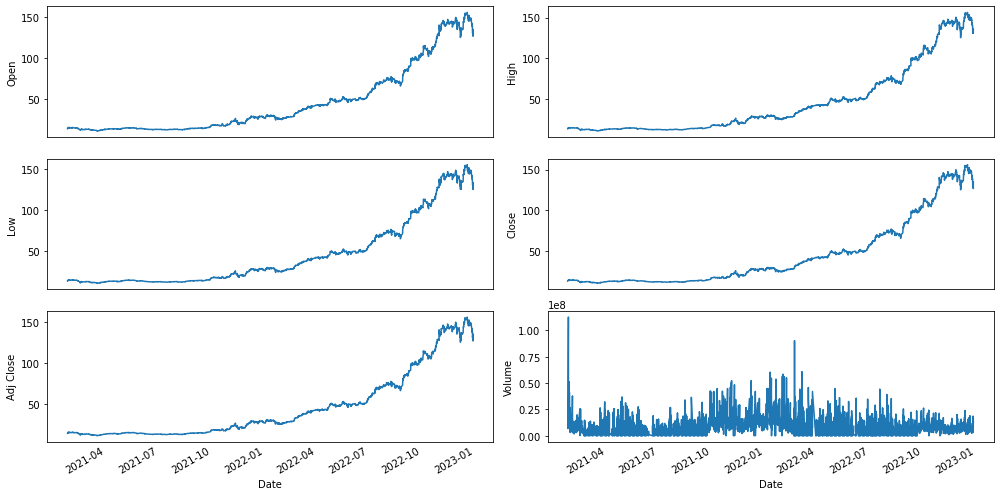

In [28]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [29]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-02-02 13:30:00+03:00,134.300,132.800,133.500,132.900,3395831,132.900
2023-02-02 14:30:00+03:00,133.300,131.600,132.900,132.000,4626281,132.000
2023-02-02 15:30:00+03:00,132.100,125.100,132.000,126.800,16885054,126.800
2023-02-02 16:30:00+03:00,131.100,126.500,126.800,130.200,14529607,130.200
2023-02-02 17:30:00+03:00,134.700,130.700,131.200,134.600,12981878,134.600


In [30]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-02-02 13:30:00+03:00,134.300,132.800,133.500,132.900,3395831
2023-02-02 14:30:00+03:00,133.300,131.600,132.900,132.000,4626281
2023-02-02 15:30:00+03:00,132.100,125.100,132.000,126.800,16885054
2023-02-02 16:30:00+03:00,131.100,126.500,126.800,130.200,14529607
2023-02-02 17:30:00+03:00,134.700,130.700,131.200,134.600,12981878


data_filtered = data_filtered.drop("Close",axis = 1)

In [31]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-02-02 13:30:00+03:00,134.300,132.800,133.500,132.900,3395831
2023-02-02 14:30:00+03:00,133.300,131.600,132.900,132.000,4626281
2023-02-02 15:30:00+03:00,132.100,125.100,132.000,126.800,16885054
2023-02-02 16:30:00+03:00,131.100,126.500,126.800,130.200,14529607
2023-02-02 17:30:00+03:00,134.700,130.700,131.200,134.600,12981878


In [32]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3933, 5)


In [33]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [34]:
np_data[1]

array([1.379e+01, 1.373e+01, 1.375e+01, 1.378e+01, 7.747e+06])

In [35]:
np_data_scaled[0]

array([0.02 , 0.021, 0.021, 0.021, 0.191])

In [36]:
np_Close_scaled[0]

array([0.021])

In [37]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(3097, 50, 5) (3097,)
(786, 50, 5) (786,)
0.02898849478580552
0.02898849478580552


In [38]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 

model.add(LSTM(n_neurons, return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

250 50 5


In [40]:
callbacks = EarlyStopping(monitor = "loss",patience = 6,verbose = 1)

In [41]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
194/194 [==============================] - 23s 100ms/step - loss: 2.8920e-04 - val_loss: 0.0023
Epoch 2/50
194/194 [==============================] - 18s 92ms/step - loss: 3.7471e-05 - val_loss: 5.5585e-04
Epoch 3/50
194/194 [==============================] - 18s 92ms/step - loss: 3.2814e-05 - val_loss: 0.0019
Epoch 4/50
194/194 [==============================] - 17s 90ms/step - loss: 4.5571e-05 - val_loss: 0.0018
Epoch 5/50
194/194 [==============================] - 18s 91ms/step - loss: 2.3282e-05 - val_loss: 1.7190e-04
Epoch 6/50
194/194 [==============================] - 18s 93ms/step - loss: 2.0590e-05 - val_loss: 0.0010
Epoch 7/50
194/194 [==============================] - 19s 98ms/step - loss: 2.8127e-05 - val_loss: 3.1952e-04
Epoch 8/50
194/194 [==============================] - 18s 94ms/step - loss: 2.5940e-05 - val_loss: 2.2287e-04
Epoch 9/50
194/194 [==============================] - 19s 96ms/step - loss: 1.7438e-05 - val_loss: 1.9299e-04
Epoch 10/50
194/194 [====

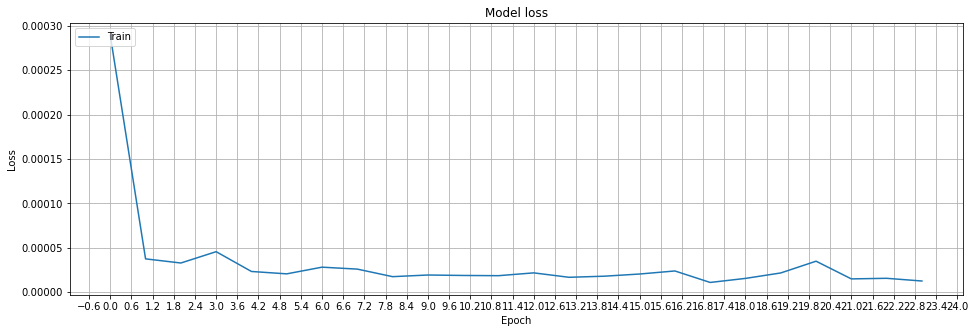

In [42]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [43]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

25/25 [==============================] - 2s 69ms/step
R2: 0.976
Median Absolute Error (MAE): 3.52
Mean Absolute Percentage Error (MAPE): 2.89 %
Median Absolute Percentage Error (MDAPE): 2.85 %


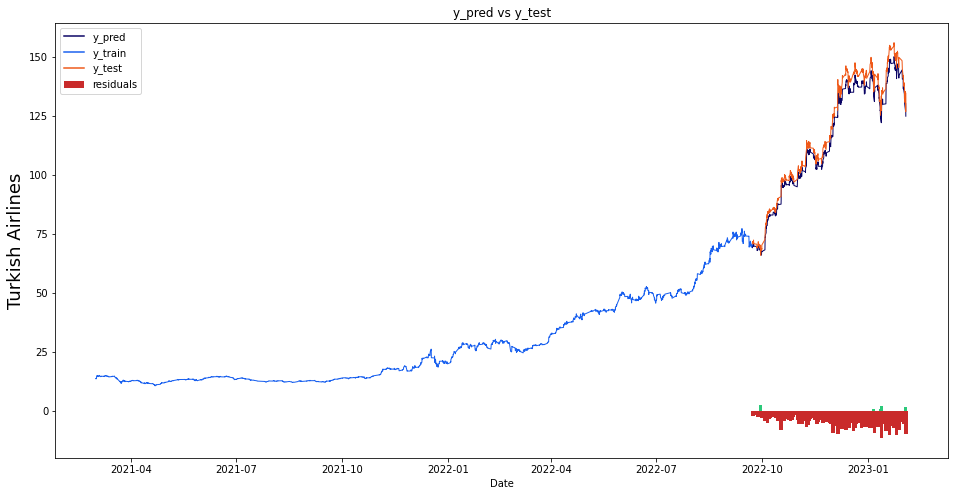

In [44]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [45]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 32ms/step
The close price for Turkish Airlines at 2023-02-03 was 134.6
The predicted close price is 128.42999267578125 (-4.8%)


## WindowSize + BatchSize Update

In [55]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(3083, 64, 5) (3083,)
(786, 64, 5) (786,)
0.028437644934134282
0.028437644934134282


In [56]:
train_data.shape

(3147, 5)

In [57]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(n_neurons,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64, 320)           417280    
                                                                 
 lstm_5 (LSTM)               (None, 320)               820480    
                                                                 
 dense_4 (Dense)             (None, 5)                 1605      
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,239,371
Trainable params: 1,239,371
Non-trainable params: 0
_________________________________________________________________


In [58]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [59]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
97/97 [==============================] - 43s 402ms/step - loss: 8.3369e-04 - val_loss: 0.0011
Epoch 2/50
97/97 [==============================] - 37s 384ms/step - loss: 1.8448e-05 - val_loss: 5.2218e-04
Epoch 3/50
97/97 [==============================] - 38s 393ms/step - loss: 1.8962e-05 - val_loss: 2.7322e-04
Epoch 4/50
97/97 [==============================] - 38s 396ms/step - loss: 2.3699e-05 - val_loss: 2.0763e-04
Epoch 5/50
97/97 [==============================] - 39s 405ms/step - loss: 2.2252e-05 - val_loss: 2.1059e-04
Epoch 6/50
97/97 [==============================] - 39s 403ms/step - loss: 2.2695e-05 - val_loss: 3.2641e-04
Epoch 7/50
97/97 [==============================] - 39s 407ms/step - loss: 1.8176e-05 - val_loss: 1.9437e-04
Epoch 8/50
97/97 [==============================] - 39s 401ms/step - loss: 2.7099e-05 - val_loss: 2.3578e-04
Epoch 9/50
97/97 [==============================] - 39s 401ms/step - loss: 1.9837e-05 - val_loss: 0.0010
Epoch 10/50
97/97 [========

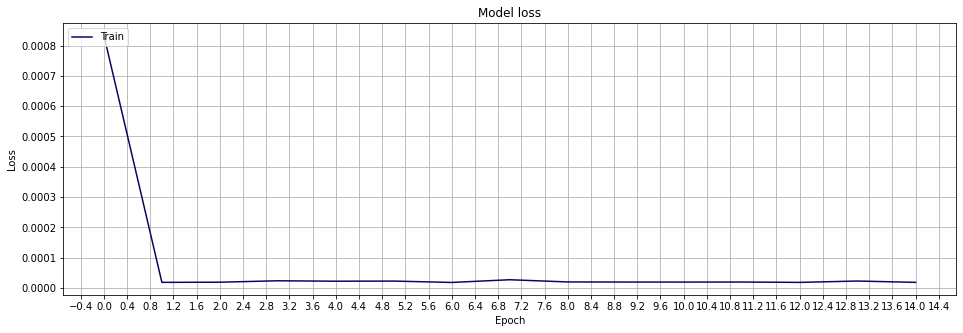

In [60]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [61]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

25/25 [==============================] - 4s 125ms/step
R2: 0.994
Median Absolute Error (MAE): 1.47
Mean Absolute Percentage Error (MAPE): 1.22 %
Median Absolute Percentage Error (MDAPE): 0.94 %


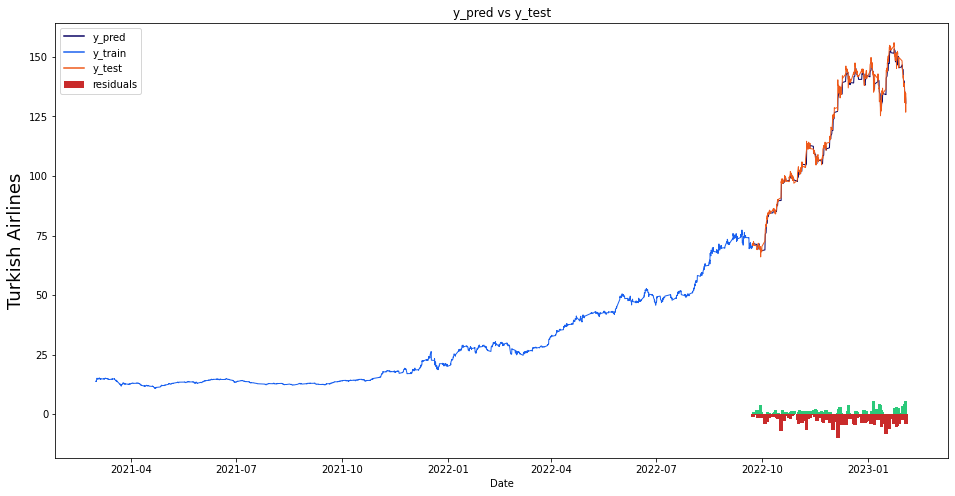

In [62]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [63]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 31ms/step
The close price for Turkish Airlines at 2023-02-03 was 134.6
The predicted close price is 130.44000244140625 (-3.19%)
